<a href="https://colab.research.google.com/github/HongEnJung/ML-DL/blob/main/ML/scikit_learn_ensemble(%EC%95%99%EC%83%81%EB%B8%94).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 앙상블 학습 개요

#### Voting Classifier

In [7]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer() # 유방암 데이터 세트

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


- Hard voting: 다수결로 최종 class 결정
- Soft voting: 분류기들의 class확률 평균값을 구하고 해당 확률이 가장 높은 클래스로 예측

In [8]:
from sklearn.model_selection import train_test_split
# 개별 학습기는 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression(max_iter=3000)
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 학습기를 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data , cancer.target,
                                                    test_size=0.2, random_state=100)

# VotongClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 학습기의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9649
LogisticRegression 정확도: 0.9561
KNeighborsClassifier 정확도: 0.9474


### Random Forest

In [9]:
import pandas as pd
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [10]:
def get_human_dataset( ):

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('/content/gdrive/MyDrive/학교/머신러닝/분류/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/content/gdrive/MyDrive/학교/머신러닝/분류/X_train.txt',sep='\s+', names=feature_name)
    X_test = pd.read_csv('/content/gdrive/MyDrive/학교/머신러닝/분류/X_test.txt',sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/content/gdrive/MyDrive/학교/머신러닝/분류/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/content/gdrive/MyDrive/학교/머신러닝/분류/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

↑ 분류 실습 때 사용한 데이터

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 결정트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


- n_estimators: DT 개수 # Decision Tree
- max_feature나 max_depth, min_sample_leaf 등의 DT와 동일함
- n_jobs = -1 은 멀티 코어 환경에서 모든 CPU 코어를 사용할 때 유용함

In [12]:
from sklearn.model_selection import GridSearchCV
# GridSearchCV 하이퍼파라미터 튜닝을 위한 도구
# 그리드 탐색(Grid Search)과 교차 검증(Cross Validation)을 결합하여 모델의 최적 하이퍼파라미터 조합을 찾는 데 사용

params = {
    'n_estimators':[50],
    'max_depth' : [8, 10],
    'min_samples_leaf' : [1, 2, 4 ],
    'min_samples_split' : [1, 2, 4]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs=-1)
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
최고 예측 정확도 : 0.9098


In [13]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth = 10, min_samples_leaf=1,
                                 min_samples_split=4, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9213


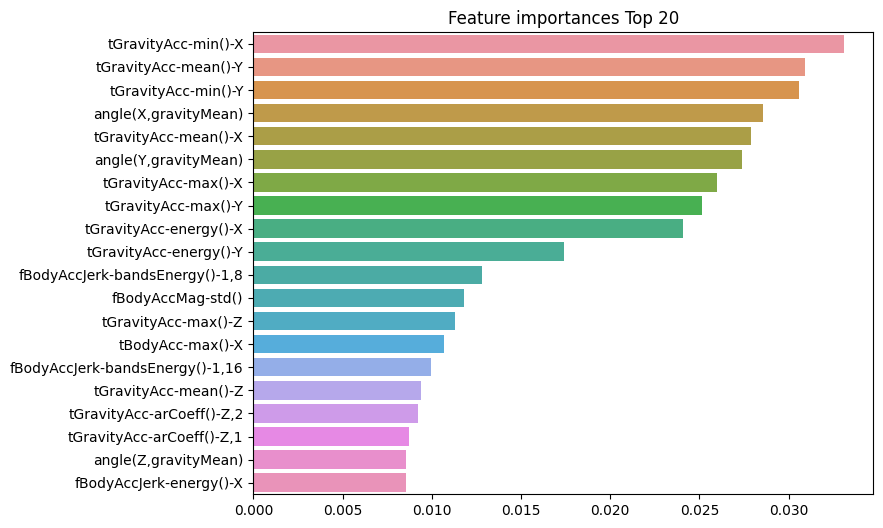

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_ # 랜덤포레스트에서 피처 중요도 추출
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### sklearn wrapper XGBoost 개요 및 적용

In [15]:
dataset = load_breast_cancer()
X_features=dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns = dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head()

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size =0.2, random_state=156)
print(X_train.shape, X_test.shape)

# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth =3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
print(accuracy_score(y_test, w_preds))

(455, 30) (114, 30)
0.9736842105263158


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred) # 혼동행렬
  accuracy = accuracy_score(y_test, pred) # 정확도
  precision = precision_score(y_test, pred) # 정밀도
  recall = recall_score(y_test, pred) # 재현율
  f1 = f1_score(y_test, pred) # F1점수
  # ROC - AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차행렬')
  print(confusion)
  # ROC - AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [18]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


In [19]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth=3)
evals =[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds =100, eval_metric='logloss',
                eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [20]:
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


In [24]:
# early_stopping_rounds를 10으로 설정하고 재 학습.
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth=3)
evals =[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds =10, eval_metric='logloss',
                eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [23]:
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9947


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

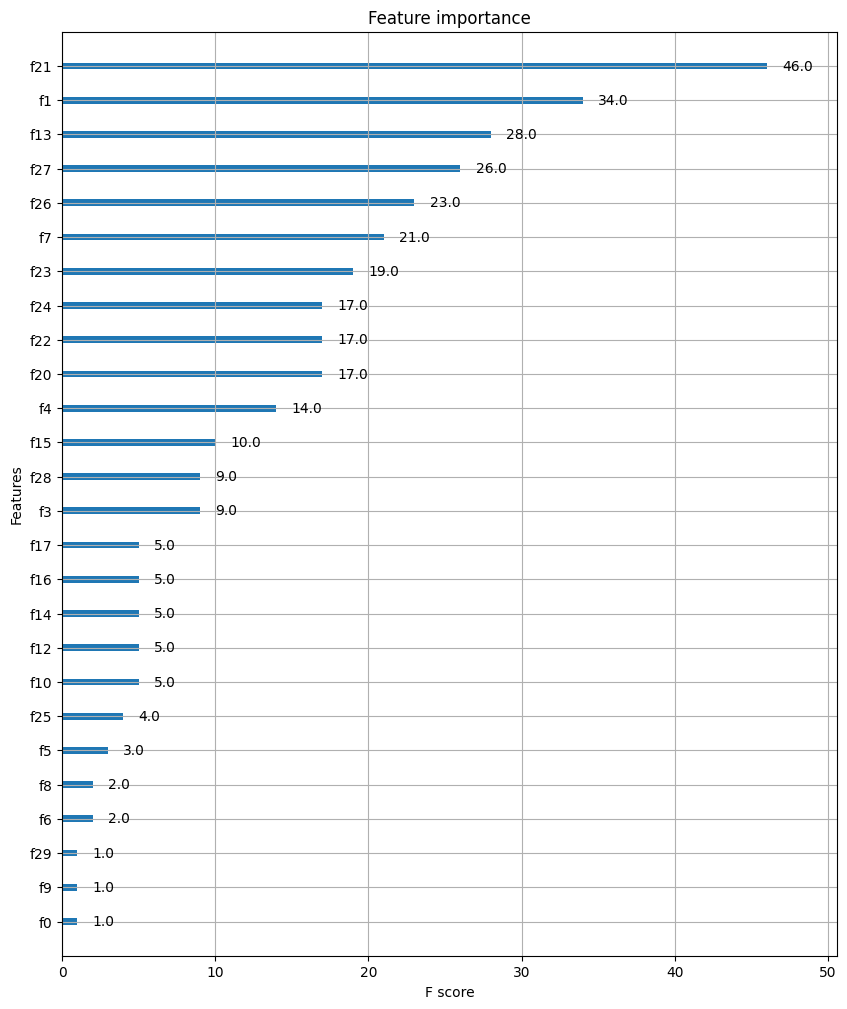

In [25]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

### 스태킹 앙상블

In [26]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2,
                                                    random_state=0)

In [27]:
# 개별 ML모델을 위한 Classifier 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier(random_state=0)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)

# 최종 Stacking 모델을 위한 Classifier 생성
lr_final = LogisticRegression(C=10, random_state =0)

In [29]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [31]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도:', np.round(accuracy_score(y_test, knn_pred),4))
print('램덤포레스트 정확도:', np.round(accuracy_score(y_test, rf_pred),4))
print('결정트리 정확도:', np.round(accuracy_score(y_test, dt_pred),4))
print('에이다부스트 정확도:', np.round(accuracy_score(y_test, ada_pred),4))

KNN 정확도: 0.9211
램덤포레스트 정확도: 0.9649
결정트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [32]:
# Stacking
pred = np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)
# transpose를 이용해 행과 열의 위치 교환, 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [36]:
lr_final.fit(pred,y_test)
final =lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737
